### Import necessary libraries and explore data ###

In [1]:
from tensorflow.keras.datasets import cifar10 #Our dataset 
from keras.utils.np_utils import to_categorical # To convert arrays to one hot encoded vectors
from tensorflow.keras.models import Sequential # Sequential model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout,MaxPooling2D, BatchNormalization, Activation # Our layers
from tensorflow.keras.callbacks import EarlyStopping # To avoid overfitting
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier # For gridsearch
from keras.models import Model

from sklearn.model_selection import train_test_split # To split data
from sklearn.model_selection import GridSearchCV # Hyperparameter tuning -> Search best params
from sklearn import metrics # For evaluation

import numpy as np # Array operations

from matplotlib import pyplot as plt # To plot
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf


In [2]:
(train_X, train_y), (test_X, test_y) = cifar10.load_data()
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (50000, 32, 32, 3)
Y_train: (50000, 1)
X_test:  (10000, 32, 32, 3)
Y_test:  (10000, 1)


In [3]:
#combinin train and test set to split later
data = np.vstack( (train_X,test_X)).copy()
data = data / 255
labels = np.vstack( (train_y,test_y)).copy()
labels = to_categorical(labels, num_classes = 10)

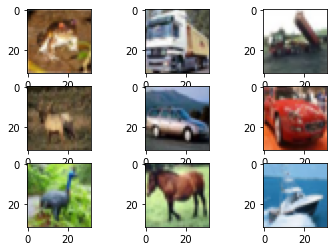

In [4]:
for i in range(9):  
    plt.subplot(330 + 1 + i)
    plt.imshow(train_X[i])
    plt.grid(False)
plt.show()

In [5]:
print("Labels: ",np.unique(train_y))

Labels:  [0 1 2 3 4 5 6 7 8 9]


**a)**  *Now you need to represent label vectors in one-hot encoded representations*

In [6]:
"""
WRITE YOUR CODES HERE
"""

y_train = to_categorical(train_y, num_classes = 10)

In [7]:
print(y_train.shape)

(50000, 10)


In [8]:
# Make scaling thus each pixel will be represented in range 0-1
# Pixel range 0-255 -> black to white
"""
WRITE YOUR CODES HERE
"""

train_X = train_X / 255
test_X = test_X / 255

*Determine input_shape*

In [9]:
"""
WRITE YOUR CODES HERE
example:
input_shape = Hello World!!
"""

input_shape = train_X.shape[1:]

## a 1.1)Build CNN ##

In [10]:
def convBlock (X, filters, kernel_size, training = True):
    
    X = Conv2D (filters=filters, kernel_size = kernel_size, strides = 1, padding = "valid")(X)
    X = BatchNormalization(axis=3)(X, training = False)
    X = Activation ('relu') (X)
    
    return X

In [11]:
def create_model(input_shape):
    """
    WRITE YOUR CODES HERE
    1)Define a sequential model
    2)Add first cnn layer
    3)Add second cnn layer
    4)Add maxpool
    5) You need to add one more spesific layer after maxpool to the shape arrangement output of the maxpool and dense layer
    """
    
    X_input = Input(input_shape)
    
    X = convBlock(X_input,32,(3,3))
    
    X = convBlock(X,64,(3,3))
    
    X = convBlock(X,128,(3,3))
    
    X = MaxPooling2D(pool_size=(3, 3),strides=(1, 1), padding='valid') (X)
    
    
    X = Flatten(name='flatten')(X)
    X = Dense(128, activation='relu', name='fc1')(X)
    X = Dropout(0.2,seed=10)(X)
    X = Dense(10, activation='softmax', name='predictions')(X)
    
    model = Model(inputs = X_input, outputs = X)
    
    model.summary()

    
    return model
    

In [12]:
#0.2 valid, 0.2 test split
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=1) # 0.25 x 0.8 = 0.2

In [13]:
#image augmentation
datagen = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.10,
                             shear_range=0.15)

In [14]:
model = create_model(input_shape = input_shape)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.000001)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5)

history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                              epochs=100, validation_data=(X_val, y_val),
                               callbacks=[early_stopping,reduce_lr])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 64)       

**Plots on below are enough for report**

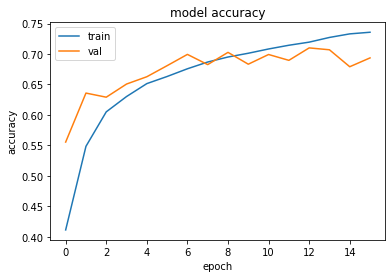

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

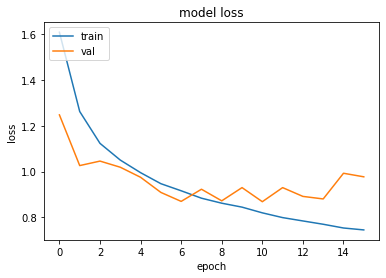

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#Reporting test accuracy

In [17]:
score_test, acc_test = model.evaluate(X_test, y_test,
                            batch_size=32)
print('test acc:' , acc_test)

300/300 [==============================] - 1s 4ms/step - loss: 0.9881 - accuracy: 0.6896
test acc: 0.6895833611488342


### a1.2) Tuning Part###

In [19]:
def create_model2(optimizer): #To give gridsearchcv algorithm we need to use optimizer variable
    """
    You can use same code part in create_model function
    """
    
    model = create_model (input_shape)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) #This line is important for grid search
    return model

In [20]:
model = KerasClassifier(build_fn=create_model2, verbose=1)

In [21]:
optimizer = ['adam','sgd', 'rmsprop']
param_grid = dict(optimizer = optimizer)
"""
    1)Define GridSearchCV with n_jobs=1,estimator,param_grid and cv
    2)Start searching best parameters with train x and train y
"""

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=5, verbose = 1, error_score = 'raise')
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
activation_6 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 28, 28, 64)        256       
____________________________________________________________

240/240 [==============================] - 1s 4ms/step - loss: 1.2894 - accuracy: 0.5293
Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_15 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
activation_15 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_16 (Batc (None, 28, 28, 64)        256       
______________________________

240/240 [==============================] - 1s 4ms/step - loss: 1.5847 - accuracy: 0.4359
Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_24 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
activation_24 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_25 (Batc (None, 28, 28, 64)        256       
______________________________

240/240 [==============================] - 1s 4ms/step - loss: 1.5826 - accuracy: 0.4529
Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_33 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
activation_33 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_34 (Batc (None, 28, 28, 64)        256       
______________________________

240/240 [==============================] - 1s 4ms/step - loss: 1.1619 - accuracy: 0.5992
Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_42 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
activation_42 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_43 (Batc (None, 28, 28, 64)        256       
______________________________

240/240 [==============================] - 1s 4ms/step - loss: 1.1823 - accuracy: 0.5882
Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_51 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
activation_51 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_52 (Batc (None, 28, 28, 64)        256       
______________________________

In [25]:
print('Best optimizer is: ', grid_result.best_params_)

Best optimizer is:  {'optimizer': 'rmsprop'}


In [32]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.572656 using {'optimizer': 'rmsprop'}
0.560000 (0.017696) with: {'optimizer': 'adam'}
0.411771 (0.027605) with: {'optimizer': 'sgd'}
0.572656 (0.032759) with: {'optimizer': 'rmsprop'}


In [24]:
"""
    Train your model with best parameters 
    1)You can use create_model function on the CNN part
    2)Compile your model with categorical_crossentropy loss, YOUR BEST OPTIMIZER and accuracy metrics.
    3)Train your model with validation_data=None,batch_size=32,epochs=13
    4)Test your model on your test data and find accuracy
"""

model = create_model(input_shape = input_shape)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.000001)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=6)

history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                              epochs=100, validation_data=(X_val, y_val),
                               callbacks=[early_stopping,reduce_lr])

Model: "functional_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_54 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
activation_54 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_55 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
activation_55 (Activation)   (None, 28, 28, 64)      

In [ ]:
score_test, acc_test = model.evaluate(X_test, y_test,
                            batch_size=32)
print('test acc:' , acc_test)

In [26]:
#Reporting test_acc

score_rms, acc_rms = model.evaluate(X_test, y_test,
                            batch_size=32)

print('Before grid search test accuracy was: ', acc_test )
print('After grid search: ' , acc_rms)

300/300 [==============================] - 1s 4ms/step - loss: 0.9609 - accuracy: 0.7094
Before grid search test accuracy was:  0.6895833611488342
After grid search:  0.7093750238418579


## b) Transfer Learning ##

In [28]:
mobileNetwork = MobileNetV2(weights='imagenet',include_top = False, input_shape=input_shape)
mobileNetwork.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 33, 33, 3)    0           input_20[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 16, 16, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 16, 16, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [29]:
keras_input = Input(shape=input_shape, name = 'image_input')
num_classes  = 10
"""
Write your code in here
Combine vggNetwork which is already defined in sequencial model with 2 FNN

"""

output_mobile_network = mobileNetwork(keras_input)
mobile_network = Flatten(name='flatten')(output_mobile_network)
mobile_network = Dense(256, activation='relu', name='fc1')(mobile_network)
mobile_network = Dense(64, activation='relu', name='fc2')(mobile_network)
mobile_network = Dense(num_classes, activation='softmax', name='predictions')(mobile_network)

model = Model(inputs=keras_input, outputs=mobile_network)

model.summary()

Model: "functional_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 32, 32, 3)]       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1, 1, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 256)               327936    
_________________________________________________________________
fc2 (Dense)                  (None, 64)                16448     
_________________________________________________________________
predictions (Dense)          (None, 10)                650       
Total params: 2,603,018
Trainable params: 2,568,906
Non-trainable params: 34,112
______________________________________

In [30]:
"""
    WRITE YOUR CODE HERE:
    Make all layers of vggNetwork non-trainable
"""

#i am not sure what you asked here but i guess you wanted to make all mobilenetwork layers untrainable and then convert
#last 3 layers of the mobile network trainable below
for layer in mobileNetwork.layers [1:-3]:
    layer.trainable = False


In [31]:
#make last 3 layers of the mobileNetwork trainable
mobileNetwork.layers[-1].trainable = True
mobileNetwork.layers[-2].trainable = True
mobileNetwork.layers[-3].trainable = True



In [28]:
"""
    Train your model
    1)You can use create_model function on the CNN part
    2)Compile your model with categorical_crossentropy loss, Adam optimizer and accuracy metrics.
    3)Train your model with validation_split=0.2,batch_size=32,epochs=100 and EarlyStopping(patience=5)
    4)Test your model on your 'test data' and find accuracy
"""

"\n    Train your model\n    1)You can use create_model function on the CNN part\n    2)Compile your model with categorical_crossentropy loss, Adam optimizer and accuracy metrics.\n    3)Train your model with validation_split=0.2,batch_size=32,epochs=100 and EarlyStopping(patience=5)\n    4)Test your model on your 'test data' and find accuracy\n"

In [32]:
model = create_model(input_shape = input_shape)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.000001)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=6)

history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                              epochs=100, validation_data=(X_val, y_val),
                               callbacks=[early_stopping,reduce_lr])

Model: "functional_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_57 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
activation_57 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_58 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
activation_58 (Activation)   (None, 28, 28, 64)      

In [33]:
score_mobile, acc_mobile = model.evaluate(X_test, y_test,
                            batch_size=32)

print('MobileNet Test acc: ', acc_mobile )


300/300 [==============================] - 1s 4ms/step - loss: 0.9460 - accuracy: 0.7078
MobileNet Test acc:  0.707812488079071
